# Why do borehles in Uganda (or anywhere) fail? 

```Key 
 🤔 means I am questioning 
 ❓ means I am asking you
```


I imagine a lot of research and thought goes into choosing the water well drill sites, but does failure correlate with geographic details, population, or political reasons? Is there a trend based on which orgnization oversaw the installation or raised the capital? Can we create an ML model to determine if correlations exist?

Firstly, what are boreholes? A borehole is a small narrow shaft drilled vertically or horizontally into the ground to  access to the water table below. 

<i>
    
- "In rural areas women are usually responsible for collecting water and they benefit by having a borehole as it lightens the burden of carrying water over long distances, saves time and reduces the danger of having to walk alone to fetch water",

- "Households and communities with boreholes are self reliant, they determine and manage their water usage and they do not have to adhere to municipal water restrictions",

- "Boreholes are beneficial to agricultural projects, farming activities and even construction projects.  Water is used for irrigation, maintaining parks and gardens, for crops, livestock and for construction purposes".  (http://www.62.co.za/blog/40-benefits-of-water-boreholes)

- Fundamentally, there is no/limited water utility system in rural locations/3rd world countries. 

- Boreholes become a viable, albiet unsustainable (?), option </i>

I don't know anything about boreholes (and you may know more). But when I started to fixate on this, there were many articles about failed boreholes and whether it is more of an infrastructure, geographic, or people based problem. It got me thinking. 

- Can I find historic data about borehole installation and function for an African country?  <span style="color:blue"> 🤔 Start small and well (?) documented (even if old)</span>

- What kind of data/info is gathered and can i decipher it? <span style="color:blue"> 🤔 Glossary or terms that could be scientifically interpretable</span>

- Is there enough variables/info to take a stab at understanding maybe what contrubtes to failure? <span style="color:blue"> </i>🤔 ML model seems useful since i don't want to force logic or a set of rules about something I don't fully understand</span>

- What would I even do with the results? <span style="color:blue"> 🤔 Find an expert!!</span>

- Can I find enough data to say anything meaningful? <span style="color:blue"> 🤔 Oh man. No clue </span>

## Let's play around with some data I found:

1. What the data looks like
2. What possible trends can we determine (if any)
3. What don't we know or what would make this problem better?

![borehole](Waterpump.jpg)

## Data Aggregation

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd


I created a geojson (vector file) from this data source https://data.humdata.org/dataset/uganda-other 
This data comes from the UN Office for the Coordination of Humanitaria Affairs, S. & E. Africa (UNOCHA-ROSEA) (https://www.unocha.org/rosea).

I actually fused this data above with ground water depth maps of Uganda from the British Geological Survey. https://www.bgs.ac.uk/research/groundwater/international/africanGroundwater/mapsDownload.html

![borehole](humdata.png)

In [7]:
gdf=gpd.read_file('uganda_acholi_water_sources_merge_clean.geojson')   #read in the merged geojson
districts=gpd.read_file('uganda_distrcits.geojson')     #let's get a map of the Uganda Distrcits for context

In [8]:
print(len(gdf))    #How big is this dataframe?

11683


In [17]:
gdf.head(5)     #Show me the first 5 entries

,index_left,X,Y,DTWAFRICA_,S_02_ID_x,DNAME_2002_x,D_02_ID_x,C_02_ID_x,SNAME_2002_x,CNAME_2002_x,...,P_02_ID,FTYPE,LABEL_P,DTW,DEPTH_clean,LOCATION,MONTH_CONS,REHAB_BY,NOTE,geometry
0,0,33.125,3.211003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,58,None,None,None,None,POINT (33.13316239620561 3.179302274159245)
1,3,33.125,3.161003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,58,None,None,None,None,POINT (33.13316239620561 3.179302274159245)
2,515,33.175,3.161003,VS,312210,PADER,312,3122,WOL,AGAGO,...,30510601,Populated Area,Laber,3.5,58,None,None,None,None,POINT (33.13316239620561 3.179302274159245)
3,0,33.125,3.211003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,49,None,None,None,None,POINT (33.13453067717418 3.180903416589643)
4,3,33.125,3.161003,VS,305106,KITGUM,305,3051,LAGORO,CHUA,...,30510601,Populated Area,Laber,3.5,49,None,None,None,None,POINT (33.13453067717418 3.180903416589643)


❓ What variables can you think of here (or otherwise) that would be valuable?

❓ What is the geospatial significance of this information?

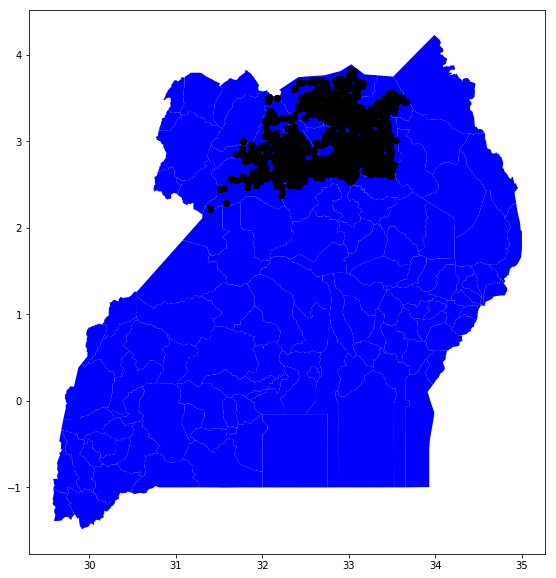

In [60]:
plt.rcParams['figure.figsize'] = (20, 10)
ax = districts.plot(color='blue')

for idx, row in gdf.iterrows():
    coordinates = row['geometry'].coords.xy
    x, y = coordinates[0][0], coordinates[1][0]

gdf.plot(ax=ax, color='black')

We really need 'categorical' information. Much of this data are strange strings/characters. 

❓ What are some things we could do to standardize this data?

❓ Why would that be beneficial?

In [19]:
gdf.STATUS=gdf.STATUS.str.lower()
gdf['STATUS']=np.where(gdf['STATUS'].str.contains("abandoned"), 1,
             np.where(gdf['STATUS'].str.contains("blocked"), 2,
             np.where(gdf['STATUS'].str.contains("condemned"), 3,
             np.where(gdf['STATUS'].str.contains("deserted"), 4,
             np.where(gdf['STATUS'].str.contains("dried up"),5,
             np.where(gdf['STATUS'].str.contains("dry"),5,
             np.where(gdf['STATUS'].str.contains("fishing required"),6,
             np.where(gdf['STATUS'].str.contains("functional"),7,
             np.where(gdf['STATUS'].str.contains("low yield"),8,
             np.where(gdf['STATUS'].str.contains("needs repair"),9,
             np.where(gdf['STATUS'].str.contains("non functional"),10,
             np.where(gdf['STATUS'].str.contains("non-functional"),10,
             np.where(gdf['STATUS'].str.contains("silted"),11,
             np.where(gdf['STATUS'].str.contains("temporary down"),12,
             np.where(gdf['STATUS'].str.contains("unknown"), 0,0)))))))))))))))

gdf['VILLAGE'] = gdf['VILLAGE'].astype('category')
cat_columns = gdf.select_dtypes(['category']).columns
gdf[cat_columns] = gdf[cat_columns].apply(lambda x: x.cat.codes)

gdf['FUND_AGENC'] = gdf['FUND_AGENC'].astype('category')
cat_columns = gdf.select_dtypes(['category']).columns
gdf[cat_columns] = gdf[cat_columns].apply(lambda x: x.cat.codes)



....Lots of the above to create a cleaned dataframe. I'll spare you the details, but took many of the variables and created integer based categories to ingest into a predictive model. We want strings to become numbers, representative of categories.

In [20]:
df=pd.read_csv('train1.csv')    #this is the cleaned guy. 

Still some weird things going on with the columns....

In [21]:
df.fillna(value=99999, inplace=True)
df=df[['X', 'Y', 'S_02_ID_x', 'DNAME_2002', 'D_02_ID_x',
       'C_02_ID_x', 'SNAME_2002_x', 'CNAME_2002_x', '2002_CENSU', 'PROJ_POP_J',
       'Urban', 'Cvrg2008', 'FID_1', 'FID_1_1', 'DISTRICT', 'VILLAGE',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE',
       'STATUS', 'DEPTH', 'SWL', 'YIELD', 'RECEIVED_N', 'RECEIVED_E',
       'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200', 'DNAME_2010',
       'DNAME_2006', 'CNAME_2006', 'SNAME_2006', 'PNAME_2006', 'FID_2',
       'D_02_ID_y', 'PNAME_2002', 'P_02_ID', 'YPE', 'LABEL_P', 'DTW',
       'DEPTH_clean', 'uid']]
#what ARE some of these variables? Little to know documentation avilable

print(len(df))

10222


We want to, basically, create a model to predict the well 'status'. This is our 'target' variable. ALl the other variables I am assuming could be used to predict this target. 

❓ What are flaws to these assumptions?

So let's see what the population of statuses that we have:


In [22]:
df.groupby('STATUS').count()['X']

STATUS
1      322
2        6
3        3
4        4
5       15
6        2
7     9790
8        4
9        3
10      52
11      21
Name: X, dtype: int64

😱 So many class '7'!!!!!!!


❓ Why would that be a problem?






In [23]:
to_remove = np.random.choice(df[df['STATUS']==7].index,size=9500,replace=False)   #OK waaay too many functional wells. 
df=df.drop(to_remove)

#pare it down to things that I can ascribe meaning to. Maybe faulty? May have removed important/meaningful information?
df_keys=df[['X', 'Y', '2002_CENSU','PROJ_POP_J', 'Urban', 'Cvrg2008',  'DISTRICT', 'VILLAGE','STATUS',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE','DEPTH', 'SWL', 'YIELD', 'RECEIVED_N',
       'RECEIVED_E', 'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200','YPE',
       'LABEL_P', 'DTW', 'DEPTH_clean','uid']]



Whew. Maybe now we are ready for ML?

## Machine Learning

In [29]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

keys=df_keys[['X', 'Y', '2002_CENSU','PROJ_POP_J', 'Urban',  'DISTRICT', 'VILLAGE',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE','DEPTH', 'SWL', 'YIELD', 'RECEIVED_N',
       'RECEIVED_E', 'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200','YPE', 'DTW', 'DEPTH_clean','uid']]
X = df_keys[['X', 'Y', '2002_CENSU','PROJ_POP_J', 'Urban',  'DISTRICT', 'VILLAGE',
       'SOURCE_NAM', 'FUND_AGENC', 'YEAR_CONST', 'SOURCE_TYP', 'OWNER_TYPE','DEPTH', 'SWL', 'YIELD', 'RECEIVED_N',
       'RECEIVED_E', 'WSSC__EXIS', 'WSSC_TRAIN', 'CONTRACTOR', 'Y_UTM200','YPE', 'DTW', 'DEPTH_clean','uid']].values.reshape(-1,25)
y = df_keys['STATUS']     #Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)



❓ What kind of ML model should we make?


In [37]:
from sklearn.linear_model import LogisticRegression

logmodel = LogisticRegression().fit(X_train, y_train)

logmodel.coef_[0]
coefs=logmodel.coef_[0]


In [38]:
top_five=np.argpartition(coefs, -5)[-5:]
print(top_five)

[22  3  9  8  7]


In [39]:
print(keys.keys()[top_five])



Index(['DTW', 'PROJ_POP_J', 'YEAR_CONST', 'FUND_AGENC', 'SOURCE_NAM'], dtype='object')


❓ Why choose logistic regression? 

Fundamentally, we want to see how the probability of a status may be affected by one or more variables


We could layer other ML-based output. Like landuse/land-classification (SVM, neural network), etc.

In [62]:
gdf.groupby('SOURCE_NAM').count()['X']  #almost like 'Anderson Land-use classes?! 
# Could we do a land-use svm/neural net on this?'

SOURCE_NAM
AD14                              2
ASTU                              2
ASTU Detacth                      2
AVSI CPD                          6
Abalo kodi                        4
Abicinia                          3
Abilonino                         3
Abim                              7
Abong Rwot                        2
Abongo peke                       3
Abuga SW                          4
Acholibur Hqrs                    3
Acholibur P/S                     4
Acord                             3
Acuru P/S                         4
Acut tonga                        4
Adaga                             3
Adilang HC                        2
Adilang SS/Bk 14                  3
Adinga                            2
Adodi                             2
Adunu West                        4
Agole                             4
Agole PS                         12
Agoro Hqrs                        3
Agoro P.7                         3
AgoroH/center                     3
Agoromin IDP     

In [43]:
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    title = title

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes  #[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax



In [44]:
np.set_printoptions(precision=2)
y_pred=logmodel.predict(X_test)



❓ Why do we predict on a 'test' set? What is unique or different about this set relative to what we trained on?

Confusion matrix, without normalization


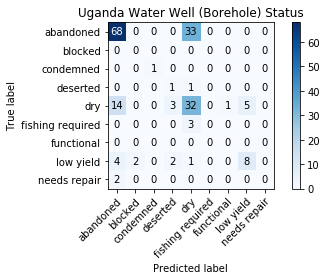

In [45]:
y_test=y_test.values.reshape((181, -1))
class_names=['abandoned','blocked','condemned','deserted','dry','fishing required','functional','low yield','needs repair','non-functional','silted']
plot_confusion_matrix(np.array(y_pred), y_test, classes=class_names,title='Uganda Water Well (Borehole) Status')


plt.show()




In [46]:
from pandas_ml import ConfusionMatrix
cm = ConfusionMatrix(y_pred, y_test[:,0])
cm.print_stats()

/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing
/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2
/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/bcm.py:191: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TP) / self.P)
/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/bcm.py:276: RuntimeWa

Confusion Matrix:

Predicted   1  2  4  5   7  8  9  10  11  __all__
Actual                                           
1          68  0  0  0  33  0  0   0   0      101
2           0  0  0  0   0  0  0   0   0        0
4           0  0  1  0   0  0  0   0   0        1
5           0  0  0  1   1  0  0   0   0        2
7          14  0  0  3  32  0  1   5   0       55
8           0  0  0  0   3  0  0   0   0        3
9           0  0  0  0   0  0  0   0   0        0
10          4  2  0  2   1  0  0   8   0       17
11          2  0  0  0   0  0  0   0   0        2
__all__    88  2  1  6  70  0  1  13   0      181


Overall Statistics:

Accuracy: 0.6077348066298343
95% CI: (0.5325521101263253, 0.6793276468616547)
No Information Rate: ToDo
P-Value [Acc > NIR]: 0.0006758566935203789
Kappa: 0.35059881752488753
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                      1          2           4   \
Population                                  181        181  

/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/bcm.py:236: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TP) / self.PositiveTest)
/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/bcm.py:267: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.FP) / self.PositiveTest)
/usr/local/lib/python3.7/site-packages/pandas_ml/confusion_matrix/bcm.py:330: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TPR) / self.FPR)
